In [69]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# NetworkX - Partitions

_The contents of this notebook have been derived from "A First Course in Network Science" by Filippo Menczer. [You can see their official Github repository here.](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/tree/master)_

Contents:

1. [Partitions](#1.-Partitions)
2. [Modularity](#2.-Modularity)
3. [Zachary's Karate Club](#3.-Zachary's-Karate-Club)
4. [Girvan-Newman clustering](#4.-Girvan-Newman-clustering)


## 1. Partitions

A **partition** of a graph is a separation of its nodes into disjoint groups. Consider the following graph:


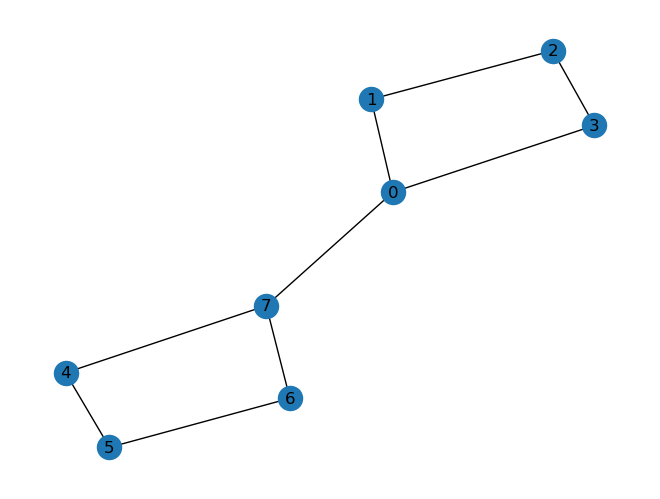

In [70]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)
plt.show()

The following is an example of a partition of these nodes:


In [71]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

Observe that every node in the graph is in exactly one of the sets in the partition. Formally, a partition is a list of sets such that every node is in exactly one set. NetworkX can verify that our partition is valid:


In [72]:
nx.community.is_partition(G, partition)

True

When developing community detection algorithms, we often make use of a _partition map_, which is a dictionary mapping node names to a partition index. This is useful for quickly comparing if two nodes are in the same cluster in the partition:


In [73]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In this dictionary, the keys are the node names and two nodes will have the same value if they are in the same partition:


In [74]:
partition_map[0] == partition_map[7]

True

We can visualize our partition by drawing the graph with nodes colored by their partition membership:


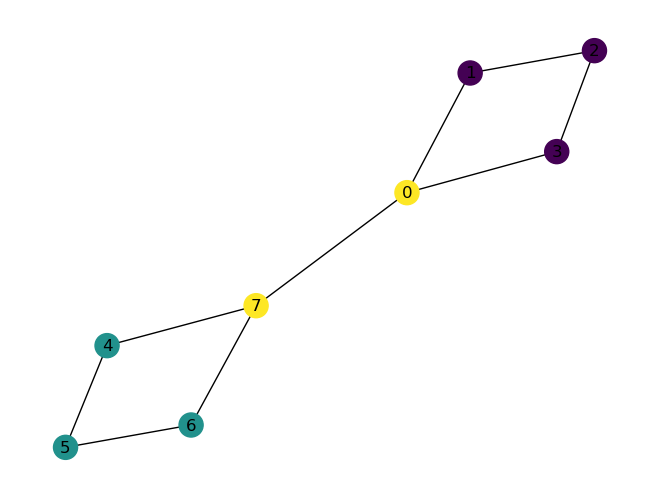

In [75]:
node_colors = [partition_map[n] for n in G.nodes]

nx.draw(G, node_color=node_colors, with_labels=True)

There are two trivial partitions:

1. The partition with one set containing every node;
2. The partition with N sets, each containing a single node.

A valid partition thus contains between 1 and N sets.

Feel free to experiment by changing the partition above and running the subsequent cells.


---


## 2. Modularity


At a high level, network community detection consists of finding a partition that achieves good separation between the groups of nodes. Before we get into how to find good partitions of a graph, we need an objective -- a way to measure how good the partition is. Modularity is one such objective function.

The modularity of a graph partition compares the number of intra-group edges with a random baseline. Higher modularity scores correspond to a higher proportion of intra-group edges, therefore fewer inter-group edges and better separation of groups.

For weighted undirected networks, as described in the text, we have

$$
Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
$$

where

- $W$ is the total weight of the links of the network,
- $W_C$ the total weight of the internal links of cluster $C$, and
- $s_C$ the total strength of the nodes of $C$.

The total weight $W$ is half the total strength for the same reason that the number of edges $L$ is half the total degree. While this formula may look a bit complicated, it's straightforward to write code to compute the sum:


In [76]:
nx.community.quality.modularity(G, partition)

0.2222222222222222

Let's compare this to a partition we would suspect to have higher modularity:


In [77]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

---


## 3. Zachary's Karate Club


When writing and testing community-detection algorithms, it helps to make use of benchmark networks: graphs with a known, "natural" community structure. Perhaps the most famous benchmark graph is Zachary's Karate Club. It contains 34 nodes, representing members of a karate club whose interactions were monitored over a period of three years by researchers. Links in this graph connect individuals interacting outside club activities, a proxy for social ties.

During the course of the study, a conflict between the instructor Mr. Hi (node 0) and the president, or Officer (node 33) led to a split of the club into separate groups led by Mr. Hi and Officer. In this case we know whom each member of the group followed after the split, providing empirical community labels: those members who followed Mr. Hi are said to be one community and those following the Officer make up the other.

For this graph, we assume that the post-split group composition was largely driven by the social ties: members of the same friend groups would want to be part of the same club after the split. We thus expect a good community-detection algorithm to predict the post-split group composition with high accuracy.

Zachary's karate club is such a popular benchmark graph that it has its own function in NetworkX:


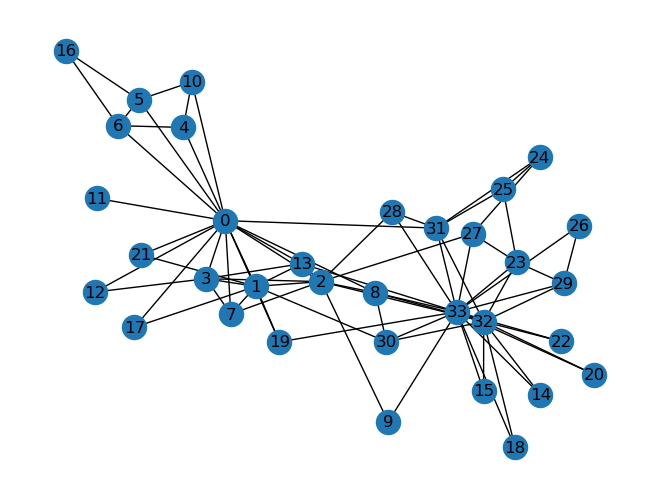

In [78]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)

Each node in a NetworkX graph has a dictionary of _attributes_ associated with it. This dictionary can hold arbitrary data about a node. We can get the attributes for a single node by giving the node name to the `nodes` object.

Each node in this graph has a `'club'` attribute, indicating whether the member followed the instructor or the president after the split:


In [79]:
K.nodes[0]

{'club': 'Mr. Hi'}

In [80]:
K.nodes[9]

{'club': 'Officer'}

We can visualize these labels by coloring each node according to its `'club'` attribute:


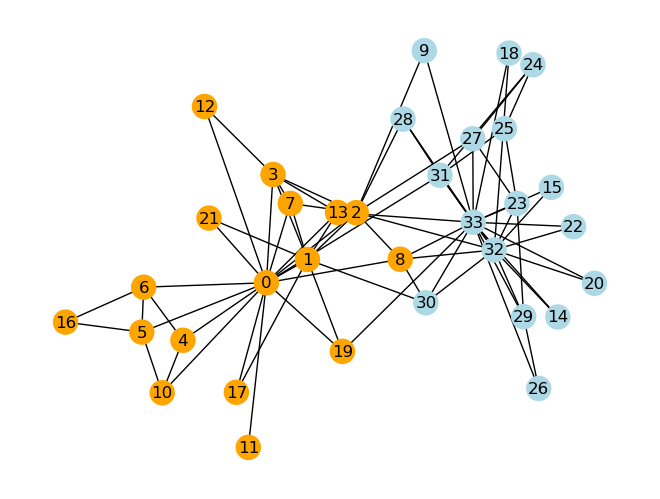

In [81]:
K = nx.karate_club_graph()
club_color = {
    "Mr. Hi": "orange",
    "Officer": "lightblue",
}
node_colors = [club_color[K.nodes[n]["club"]] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)

This separation looks good, in that there are relatively few inter-community links as opposed to intra-community links. Let's create a graph partition based on these labels and measure its modularity.

We can do this by creating a dictionary of two sets, one for each value of the nodes' `'club'` attribute, then assigning the nodes to the corresponding set.


In [82]:
groups = {
    "Mr. Hi": set(),
    "Officer": set(),
}

for n in K.nodes:
    club = K.nodes[n]["club"]
    groups[club].add(n)

groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}

By using the dictionary's `.values()` method, we can get a list of sets that define our partition:


In [83]:
empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [84]:
nx.community.is_partition(K, empirical_partition)

True

Since our partition is indeed a valid partition, we can get the modularity of this partition:


In [85]:
nx.community.quality.modularity(K, empirical_partition)

0.39143756676224206

This is a relatively high modularity, which is what we expect.

### Comparison to a random partition

For the sake of comparison, let's generate a random partition of this network and check its modularity. We would expect a modularity close to zero in this case.

First we generate a sample of 17 nodes, half the total number of nodes, and assign them to one community. Our second community then includes the nodes in the graph not in the first community. We can use some set arithmetic to do this concisely:


In [86]:
random_nodes = random.sample(sorted(K.nodes), 17)
random_partition = [set(random_nodes), set(K.nodes) - set(random_nodes)]
random_partition

[{0, 1, 4, 5, 6, 8, 14, 15, 18, 19, 22, 25, 26, 27, 29, 32, 33},
 {2, 3, 7, 9, 10, 11, 12, 13, 16, 17, 20, 21, 23, 24, 28, 30, 31}]

We can visualize this partition and observe that the communities are much less natural-looking, as we would expect from a random assignment.


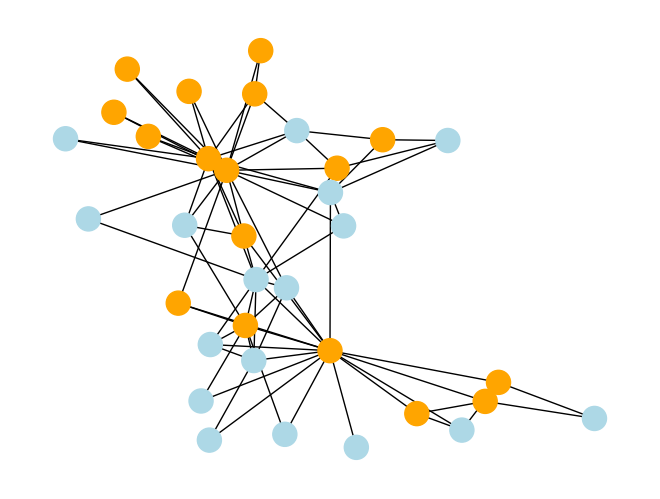

In [87]:
random_node_colors = ["orange" if n in random_nodes else "lightblue" for n in K.nodes]
nx.draw(K, node_color=random_node_colors)

And finally we can test the modularity of this partition:


In [88]:
nx.community.quality.modularity(K, random_partition)

-0.08526826708644887

Since this is a random process the modularity won't be exactly zero, but it should be fairly close. Go ahead and repeat the process of generating a random partition and testing its modularity -- it will fluctuate around its mean value of zero.


---


## 4. Girvan-Newman clustering


Our task in this part will be to implement the Girvan-Newman clustering algorithm. Since NetworkX can do the heavy lifting for us -- computing betweenness centrality -- the code part of the task is relatively straightforward. Most of our effort here is spent interpreting and explaining intermediate results.

Recall from the text the Girvan-Newman clustering algorithm:

1. Create a partition sequence
1. Calculate the betweenness centrality for all links.
1. Remove the link with largest betweenness and create a partition using connected components.
1. Recalculate the betweenness centrality of the links of the resulting graph.
1. Repeat from step B until no links remain.
1. Evaluate each partition in the sequence and choose the one with the highest modularity.

During this process, the number of connected components in the graph will increase monotonically as clusters are broken up. Since we are removing one link at a time, the number of connected components can increase by at most one between steps in the sequence -- it's not possible for a single edge to connect more than two nodes, and thus components.

We hope that the resulting partition of the graph will approximate its underlying community structure. We'll use the Karate Club graph here because we know the ground-truth community labels and can compare the result obtained from the algorithm.


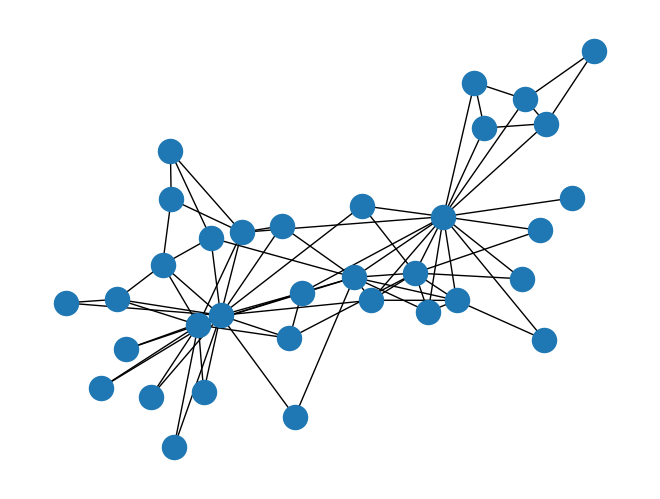

In [89]:
G = nx.karate_club_graph()
nx.draw(G)

### 4.1 Create a partition sequence

#### A. Calculate the betweenness centrality for all links

NetworkX does the heavy lifting here. All we need to do is understand the output.


In [90]:
nx.edge_betweenness_centrality(G)

{(0, 1): 0.025252525252525245,
 (0, 2): 0.0777876807288572,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.04237189825425121,
 (0, 17): 0.04012392835922248,
 (0, 19): 0.045936960642843,
 (0, 21): 0.040123928359222474,
 (0, 31): 0.1272599949070537,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.01869960105254222,
 (1, 19): 0.014633732280791102,
 (1, 21): 0.01869960105254222,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384543,
 (3, 7): 0.00336558

The resulting dictionary has edge tuples as the keys, and each associated value is the betweenness centrality of that edge. The algorithm to compute the edge betweenness of all edges in a graph costs about the same as calculating it for a single edge, so we'll make use of this dictionary with the computed values for every edge.

Once computed for all edges, we can easily get the associated betweenness for a single edge. For example, to get the edge betweenness of the edge between nodes 0 and 1:


In [91]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
my_edge_betweenness[0, 1]

0.025252525252525245

Recall that dictionaries also have the `.get` method. This will be used in the next step.


In [92]:
my_edge_betweenness.get((0, 1))

0.025252525252525245

#### B. Remove the link with largest betweenness...

Given this dictionary of betweenness values for each edge, we can make use of Python's builtin `max` function to give us the key in this dictionary with the greatest value. Since there is a key in the dictionary for each edge in the graph, the following two expressions are equivalent, but the second one is probably more explicit as to what we're doing with this statement.

I'm using the name `my_edge_betweenness` to make clear that this is a dictionary we've named and not a NetworkX function.


In [93]:
max(my_edge_betweenness, key=my_edge_betweenness.get)

(0, 31)

In [94]:
max(G.edges(), key=my_edge_betweenness.get)

(0, 31)

This is then the edge we want to remove at this step in the process:


In [95]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
G.remove_edge(*most_valuable_edge)

The "splat" in the last statement above `G.remove_edge(*most_valuable_edge)` performs tuple unpacking into the arguments of a function. For example, if our most valuable edge is `(0, 31)`,

    G.remove_edge(*most_valuable_edge)

is the same as

    G.remove_edge(most_valuable_edge[0], most_valuable_edge[1])

or

    G.remove_edge(0, 31)


### B. (cont'd) ...and create a partition using connected components

This one is almost a gimme because the `nx.connected_components()` function gives us almost exactly what we want:


In [96]:
nx.connected_components(G)

<generator object connected_components at 0x000001B2EF70E6B0>

We just have to remember to ask for it in a list:


In [97]:
list(nx.connected_components(G))

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}]

Remember: a partition is a list of sets where every node is in exactly one of these sets. This is just what we have here, although it's a bit boring since we've only removed one edge and so there is still one connected component. If you like, you can try running the previous two cells a few times until you have more than one connected component so you can see what that looks like.

Note that this feature whereby the connected components correspond exactly to our putative community labels is particular to the Girvan-Newman algorithm: other clustering algorithms may use different ways of generating their partitions.


### C. Recalculate the betweenness centrality of the links of the resulting graph.

### D. Repeat from step B until no links remain.

This implies that we need a loop to repeat this process $L$ times, once for each edge, and that we should keep track of the partitions generated. Straightforward stuff. We'll start with a fresh Karate Club graph since we removed some edges above:


In [98]:
G = nx.karate_club_graph()
partition_sequence = []
for _ in range(G.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(G)
    most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
    G.remove_edge(*most_valuable_edge)
    my_partition = list(nx.connected_components(G))
    partition_sequence.append(my_partition)

Note the idiomatic construction of this `for` loop. Using `_` as the name for the loop variable tells the reader that we don't expect to do anything with the loop variable -- we just want to perform a task a specific number of times. One might be tempted to use a `while` loop here, but that way lie dragons: a mistake in a `while` loop can lead to infinite loops which are a headache.

If we've done this right, we should have a partition for each step of the process, _i.e._ one for each edge in the graph:


In [99]:
len(partition_sequence), nx.karate_club_graph().number_of_edges()

(78, 78)

Since we started with a connected graph, removing one edge probably doesn't disconnect the graph, so our first partition probably only has one community:


In [100]:
len(partition_sequence[0])

1

...and the last partition should also be trivial, with each node in its own community:


In [101]:
len(partition_sequence[-1]), nx.karate_club_graph().number_of_nodes()

(34, 34)

### 4.2 Evaluate the modularity of each partition in the sequence

We now have a sequence of partitions and a function to calculate the modularity of a partition. This is a great time to use a list comprehension!


In [ ]:
G = nx.karate_club_graph()
modularity_sequence = [
    nx.community.quality.modularity(G, p) for p in partition_sequence
]
modularity_sequence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3476602762317048,
 0.3476602762317048,
 0.3476602762317048,
 0.3423192968647514,
 0.3423192968647514,
 0.3423192968647514,
 0.3423192968647514,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3849721706864564,
 0.37578006409175235,
 0.37578006409175235,
 0.3594760218136841,
 0.3594760218136841,
 0.3470699574595678,
 0.3470699574595678,
 0.33324900208017094,
 0.33324900208017094,
 0.31344052772624204,
 0.31344052772624204,
 0.3122598901819681,
 0.3122598901819681,
 0.30368621277712193,
 0.30368621277712193,
 0.29429733325837226,
 0.29429733325837226,
 0.28271584115739956,
 0.28271584115739956,
 0.27116245947414774,
 0.27116245947414774,
 0.2544648713479881,
 0.2544648713479881,
 0.23975375274076566,
 0.23975375274076566,
 0.2268979217031164,
 0.22299057363992417,
 0.22299057363992417,
 0.22299057363992417,
 0.20056783043796028,
 0.20056783043796

This sequence is then the modularity of the partition at each step in the algorithm. The first several entries in this sequence are effectively zero while there is only one community/component, then it jumps up once there is more than one community. We can use pyplot to visualize this relationship:


Text(0.5, 0, 'Algorithm step')

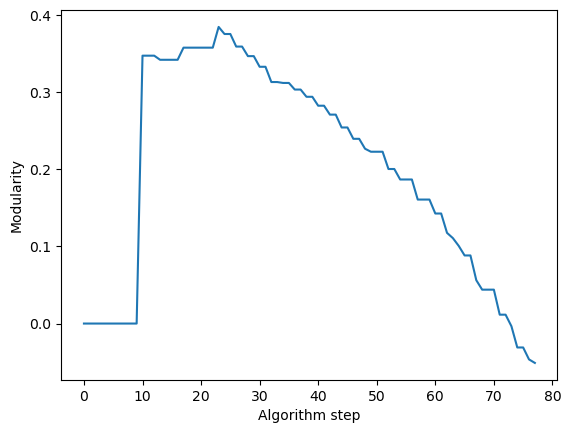

In [118]:
plt.plot(modularity_sequence)
plt.ylabel("Modularity")
plt.xlabel("Algorithm step")

### Get the partition with highest modularity


Visually, we see a peak in the modularity sequence. This is the partition that maximizes modularity, and thus the output of the algorithm. We can use the `max` function to get the partition with highest modularity. Ideally we want to write the following:


In [119]:
best_partition = max(partition_sequence, key=nx.community.quality.modularity)

TypeError: modularity() missing 1 required positional argument: 'communities'

...but we receive an error. Recall that a key function must take exactly one argument, the item in the sequence being evaluated, but the modularity function takes two arguments: the graph and the partition. We can fix this by writing a single-argument function to use as the key:


In [105]:
def my_modularity(partition):
    return nx.community.quality.modularity(G, partition)


best_partition = max(partition_sequence, key=my_modularity)

Advanced Pythonauts will see a differet solution to this using the `zip` function to align the previously-generated partition & modularity sequences, but this solution is more explicit.

So after all that work, what is the best partition?


In [106]:
best_partition

[{0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
 {2, 24, 25, 27, 28, 31},
 {4, 5, 6, 10, 16},
 {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
 {9}]

Interesting! The partition of the karate club graph with highest modularity actually has five components! Let's visualize them, using our code for partition maps we wrote back at the beginning of this tutorial:


In [107]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

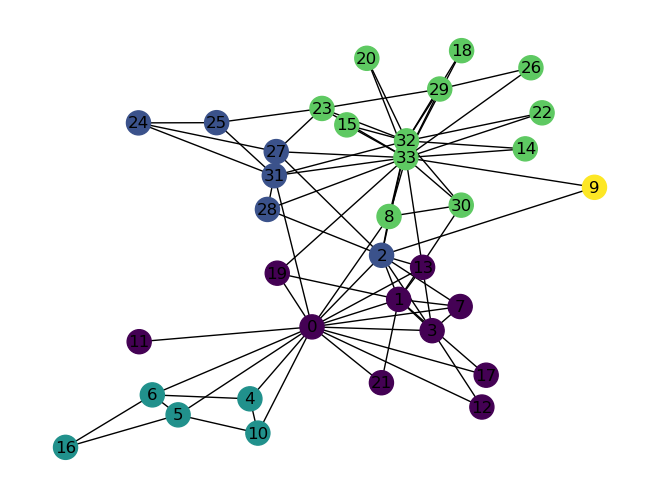

In [108]:
best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

Exactly how good is this five-community clustering?


In [109]:
nx.community.quality.modularity(G, best_partition)

0.3849721706864564

It's higher than the "ground truth" communities we evaluated in section 3, which is a good sign, but for the specific problem of trying to predict the post-split community membership, a clustering into five groups is useless to us.

### Get the best partition with a given number of communities

One of the most useful parts of the Girvan-Newman algorithm is that it is also useful when we have a specific number of clusters we want. In this case, we know the karate club split into two groups, so let's get the partition in the sequence with two components:


In [110]:
for partition in partition_sequence:
    if len(partition) == 2:
        two_cluster_partition = partition
        break

two_cluster_partition

[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

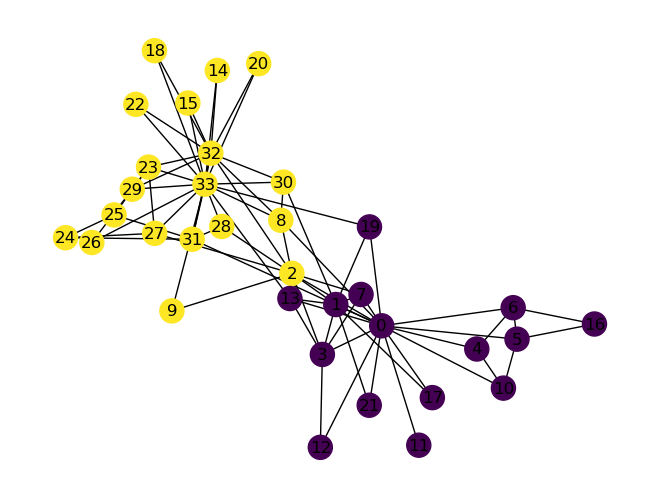

In [111]:
two_cluster_partition_map = create_partition_map(two_cluster_partition)

node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

How good is this partition? We can get its modularity:


In [112]:
nx.community.quality.modularity(G, two_cluster_partition)

0.3476602762317048

Pretty good -- comparable to the ground truth community labels. Let's compare these side-by-side:


Text(0.5, 1.0, 'Actual communities')

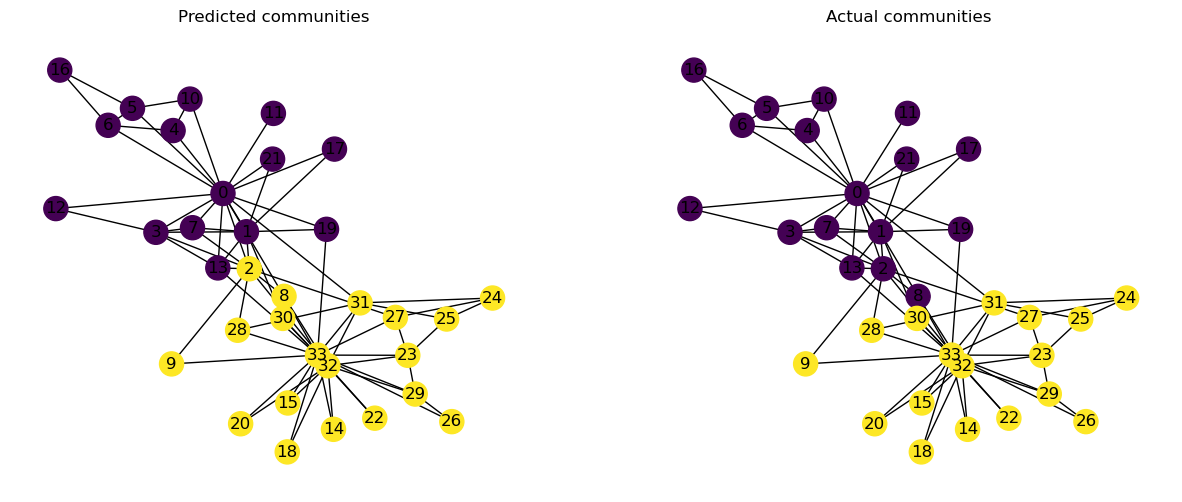

In [120]:
pos = nx.layout.spring_layout(G)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
two_cluster_partition_map = create_partition_map(two_cluster_partition)
node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title("Predicted communities")

plt.subplot(1, 2, 2)
node_colors = [G.nodes[n]["club"] == "Officer" for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title("Actual communities")

We can see that the predicted community labels are pretty accurate, only differing on a couple nodes that, visually, seem like they could plausibly beling to either group. Zachary's original paper even explains the practical considerations of one of these mispredicted nodes: student 8 was very near receiving his black belt from Mr. Hi and thus did not want to leave the group even though several of his friends did.


In [114]:
G.nodes[8]

{'club': 'Mr. Hi'}

#### Aside

The astute reader might note that there may be several two-cluster partitions in the partition sequence we generated. We assert the following to be true:

1. For every integer 1 to N, the number of nodes, there is a partition in the sequence with that number of clusters
2. Every partition in the sequence with the same number of clusters is the same

Proving these is left as an exercise to the reader, but as a consequence of these being true, optimized implementations of Girvan-Newman clustering will only store one partition for each number of clusters. This is how the implementation in NetworkX works, only providing one partition for each number of communities greater than one.


## NetworkX Function

`nx.community.girvan_newman(G)` will generate a sequence containing one partition of each size greater than one. Here we can see the first several are the same as those we generated:


In [121]:
list(nx.community.girvan_newman(G))[:5]

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}),
 ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {4, 5, 6, 10, 16},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9}),
 ({0, 1, 3, 7, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9},
  {11})]

---
